In [ ]:
"""
Emergent Constraints Analysis using Skyborn Package

This notebook demonstrates the emergent constraint method for climate data analysis.
Method adapted from: https://github.com/blackcata/Emergent_Constraints/tree/master

References:
- Cox, P. M., et al. (2013). Nature, 494(7437), 341-344.
"""

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import os
import sys

# Add Skyborn to path
sys.path.insert(0, os.path.join(os.path.dirname('__file__'), 'src'))

# Import Skyborn emergent constraint functions (new improved names)
from skyborn.calc import (
    gaussian_pdf,
    emergent_constraint_posterior,
    emergent_constraint_prior,
    # Legacy functions for compatibility
    calc_GAUSSIAN_PDF,
    calc_PDF_EC,
    calc_PDF_EC_PRIOR
)

# Set plotting parameters for high-quality figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

# Use seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("husl")

%config InlineBackend.figure_format = 'retina'

In [ ]:
print("📦 Package Versions:")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   matplotlib: {plt.matplotlib.__version__}")
print(f"   xarray: {xr.__version__}")

print("\n🧮 Skyborn Emergent Constraint Functions:")
print("   ✅ gaussian_pdf - Calculate Gaussian PDF")
print("   ✅ emergent_constraint_posterior - Apply emergent constraints")
print("   ✅ emergent_constraint_prior - Calculate prior distributions")

print("\n📊 Data Visualization Setup:")
print("   ✅ High-resolution figures (300 DPI)")
print("   ✅ Seaborn styling enabled")
print("   ✅ Color palette optimized")

print("\n🔗 Reference Implementation:")
print("   https://github.com/blackcata/Emergent_Constraints/tree/master")

# Test basic functionality
test_x = np.linspace(-3, 3, 100)
test_pdf = gaussian_pdf(mu=0, sigma=1, x=test_x)
print(f"\n✅ Function test successful - PDF max: {test_pdf.max():.4f}")

pandas version : 1.4.3
numpy version : 1.20.2
xarray version : 0.18.2


# 🌍 Climate Data Analysis with Emergent Constraints

## Overview

This notebook demonstrates the application of **emergent constraint methods** to climate model data. Emergent constraints are a powerful technique in climate science for reducing uncertainty in future projections by leveraging observable relationships between present-day variability and future changes.

### Key Concepts:
- **Constraint Variable**: Observable quantity that correlates with the target variable
- **Target Variable**: Future projection we want to constrain  
- **Observational PDF**: Probability distribution of observed constraint values
- **Posterior PDF**: Constrained probability distribution of the target variable

### Method Reference:
This implementation is adapted from the work by **blackcata**: https://github.com/blackcata/Emergent_Constraints/tree/master

Based on the seminal paper by Cox et al. (2013) in Nature.

## 📁 Data Loading and Preprocessing

In [ ]:
# Data directory
data_dir = './DATA/'

# Available data files
data_files = {
    'CMIP5': {
        'CHL': 'Delta_annual_CHL_CMIP5_Lat_6690.nc',
        'NO3': 'Delta_annual_NO3_CMIP5_Lat_6690.nc', 
        'PP': 'Delta_annual_PP_CMIP5_Lat_6690.nc'
    },
    'CMIP6': {
        'CHL': 'Delta_annual_CHL_CMIP6_Lat_6690.nc',
        'NO3': 'Delta_annual_NO3_CMIP6_Lat_6690.nc',
        'PP': 'Delta_annual_PP_CMIP6_Lat_6690.nc'
    }
}

def load_climate_data(experiment: str, variable: str) -> xr.Dataset:
    """
    Load climate model data with error handling.
    
    Parameters:
    -----------
    experiment : str
        Either 'CMIP5' or 'CMIP6'
    variable : str  
        Either 'CHL', 'NO3', or 'PP'
        
    Returns:
    --------
    xr.Dataset
        Loaded dataset
    """
    try:
        filepath = os.path.join(data_dir, data_files[experiment][variable])
        if not os.path.exists(filepath):
            print(f"⚠️  File not found: {filepath}")
            return None
            
        dataset = xr.open_dataset(filepath)
        print(f"✅ Loaded {experiment} {variable} data: {dataset.dims}")
        return dataset
        
    except Exception as e:
        print(f"❌ Error loading {experiment} {variable}: {e}")
        return None

# Check data availability
print("🔍 Checking data availability...")
for exp in ['CMIP5', 'CMIP6']:
    for var in ['CHL', 'NO3', 'PP']:
        filepath = os.path.join(data_dir, data_files[exp][var])
        status = "✅" if os.path.exists(filepath) else "❌"
        print(f"   {status} {exp} {var}: {data_files[exp][var]}")
        
print(f"\n📂 Data directory: {os.path.abspath(data_dir)}")

## 📊 Emergent Constraint Analysis

Now we'll demonstrate the emergent constraint method using the loaded climate data.

In [ ]:
def create_emergent_constraint_demo():
    """
    Demonstrate emergent constraint method with synthetic data and visualization.
    
    References:
    -----------
    Adapted from: https://github.com/blackcata/Emergent_Constraints/tree/master
    """
    
    # Generate synthetic climate model data
    np.random.seed(42)
    n_models = 25
    
    # Constraint variable (e.g., present-day sensitivity parameter)
    x_constraint = np.random.normal(3.2, 0.7, n_models)
    
    # Target variable with emergent relationship + noise
    true_slope = 1.8
    true_intercept = 2.5
    noise_std = 0.4
    y_target = true_slope * x_constraint + true_intercept + np.random.normal(0, noise_std, n_models)
    
    # Observational constraint (simulated)
    obs_mean = 3.0
    obs_std = 0.15
    
    # Create grids for PDF calculations
    x_grid = np.linspace(1.5, 5.0, 80)
    y_grid = np.linspace(4.0, 11.0, 80)
    
    # Calculate observational PDF
    obs_pdf = gaussian_pdf(obs_mean, obs_std, x_grid)
    
    # Convert to xarray for compatibility
    constraint_data = xr.DataArray(x_constraint, dims=['model'], 
                                   attrs={'long_name': 'Constraint Variable',
                                         'units': 'sensitivity_units'})
    target_data = xr.DataArray(y_target, dims=['model'],
                              attrs={'long_name': 'Target Variable', 
                                    'units': 'projection_units'})
    
    # Apply emergent constraint using new function names
    posterior_pdf, posterior_std, posterior_mean = emergent_constraint_posterior(
        constraint_data, target_data, x_grid, y_grid, obs_pdf
    )
    
    # Calculate prior for comparison
    prior_pdf, prediction_error, regression_line = emergent_constraint_prior(
        constraint_data, target_data, x_grid, y_grid
    )
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    
    # Subplot 1: Inter-model relationship
    ax1 = plt.subplot(2, 3, 1)
    scatter = ax1.scatter(x_constraint, y_target, c=range(n_models), 
                         cmap='viridis', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add regression line
    z = np.polyfit(x_constraint, y_target, 1)
    p = np.poly1d(z)
    ax1.plot(x_grid, p(x_grid), "r--", alpha=0.8, linewidth=2, label=f'Regression: y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax1.axvline(obs_mean, color='orange', linestyle='-', linewidth=3, alpha=0.8, label=f'Observation: {obs_mean}±{obs_std}')
    ax1.fill_betweenx([y_target.min(), y_target.max()], obs_mean-obs_std, obs_mean+obs_std, 
                      alpha=0.3, color='orange')
    
    ax1.set_xlabel('Constraint Variable (Present-day)', fontsize=12)
    ax1.set_ylabel('Target Variable (Future)', fontsize=12) 
    ax1.set_title('🔗 Inter-model Relationship', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar for models
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar.set_label('Model Index', fontsize=10)
    
    # Subplot 2: Observational constraint
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(x_grid, obs_pdf, 'orange', linewidth=3, label='Observational PDF')
    ax2.fill_between(x_grid, obs_pdf, alpha=0.3, color='orange')
    ax2.axvline(obs_mean, color='red', linestyle='--', alpha=0.8)
    ax2.set_xlabel('Constraint Variable', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.set_title('📊 Observational Constraint', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Prior vs Posterior comparison
    ax3 = plt.subplot(2, 3, 3)
    
    # Calculate unconstrained statistics
    unconstrained_mean = y_target.mean()
    unconstrained_std = y_target.std()
    
    # Plot distributions
    y_dense = np.linspace(y_grid.min(), y_grid.max(), 200)
    unconstrained_pdf = gaussian_pdf(unconstrained_mean, unconstrained_std, y_dense)
    
    ax3.plot(y_dense, unconstrained_pdf, 'blue', linewidth=2, alpha=0.7, label=f'Unconstrained\n(μ={unconstrained_mean:.2f}, σ={unconstrained_std:.2f})')
    ax3.plot(y_grid, posterior_pdf/posterior_pdf.max() * unconstrained_pdf.max(), 'red', linewidth=3, 
             label=f'Constrained\n(μ={posterior_mean:.2f}, σ={posterior_std:.2f})')
    
    ax3.fill_between(y_dense, unconstrained_pdf, alpha=0.3, color='blue')
    ax3.fill_between(y_grid, posterior_pdf/posterior_pdf.max() * unconstrained_pdf.max(), alpha=0.4, color='red')
    
    ax3.axvline(unconstrained_mean, color='blue', linestyle='--', alpha=0.7)
    ax3.axvline(posterior_mean, color='red', linestyle='--', alpha=0.7)
    
    ax3.set_xlabel('Target Variable (Future)', fontsize=12)
    ax3.set_ylabel('Normalized Probability Density', fontsize=12)
    ax3.set_title('📈 Constraint Effect', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Subplot 4: Uncertainty reduction
    ax4 = plt.subplot(2, 3, 4)
    
    categories = ['Unconstrained', 'Constrained']
    means = [unconstrained_mean, posterior_mean]
    stds = [unconstrained_std, posterior_std]
    colors = ['blue', 'red']
    
    bars = ax4.bar(categories, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value annotations
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax4.annotate(f'{mean:.2f}±{std:.2f}', 
                    xy=(i, mean), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontweight='bold')
    
    reduction_percent = (1 - posterior_std/unconstrained_std) * 100
    ax4.set_ylabel('Target Variable Value', fontsize=12)
    ax4.set_title(f'📉 Uncertainty Reduction: {reduction_percent:.1f}%', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Subplot 5: Model space visualization
    ax5 = plt.subplot(2, 3, 5)
    
    # Create 2D histogram of model data
    hist, xedges, yedges = np.histogram2d(x_constraint, y_target, bins=15)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax5.imshow(hist.T, extent=extent, origin='lower', cmap='Blues', alpha=0.7)
    ax5.scatter(x_constraint, y_target, c='darkblue', s=30, alpha=0.8, edgecolors='white', linewidth=0.5)
    
    # Add observational constraint
    ax5.axvline(obs_mean, color='orange', linewidth=3, label='Observation')
    ax5.fill_betweenx([yedges[0], yedges[-1]], obs_mean-obs_std, obs_mean+obs_std, 
                      alpha=0.3, color='orange')
    
    ax5.set_xlabel('Constraint Variable', fontsize=12)
    ax5.set_ylabel('Target Variable', fontsize=12)
    ax5.set_title('🌐 Model Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    
    # Add colorbar
    cbar2 = plt.colorbar(im, ax=ax5, shrink=0.8)
    cbar2.set_label('Model Density', fontsize=10)
    
    # Subplot 6: Summary statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create summary text
    summary_text = f"""
    📋 ANALYSIS SUMMARY
    
    🔍 Method: Emergent Constraints
    📊 Models: {n_models}
    🎯 Observation: {obs_mean:.2f} ± {obs_std:.2f}
    
    📈 RESULTS:
    • Unconstrained Mean: {unconstrained_mean:.2f}
    • Constrained Mean: {posterior_mean:.2f}
    • Uncertainty Reduction: {reduction_percent:.1f}%
    
    🔗 RELATIONSHIP:
    • Correlation: {np.corrcoef(x_constraint, y_target)[0,1]:.3f}
    • Slope: {z[0]:.2f}
    • R²: {stats.pearsonr(x_constraint, y_target)[0]**2:.3f}
    
    📚 Reference:
    github.com/blackcata/Emergent_Constraints
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('🌍 Emergent Constraint Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.93)
    
    return {
        'constraint_data': constraint_data,
        'target_data': target_data, 
        'posterior_pdf': posterior_pdf,
        'posterior_mean': posterior_mean,
        'posterior_std': posterior_std,
        'unconstrained_mean': unconstrained_mean,
        'unconstrained_std': unconstrained_std,
        'uncertainty_reduction': reduction_percent
    }

# Run the demonstration
print("🚀 Running emergent constraint demonstration...")
results = create_emergent_constraint_demo()
plt.show()

print(f"\n✅ Analysis complete!")
print(f"📊 Uncertainty reduced by {results['uncertainty_reduction']:.1f}%")
print(f"🎯 Constrained projection: {results['posterior_mean']:.2f} ± {results['posterior_std']:.2f}")

In [6]:
def mean_weighted_latlon(var):
    
    weights      = np.cos(np.deg2rad(var.lat))
    weights.name = "weights"    
    var_weighted = var.weighted(weights).mean(("lat","lon"))
    
    return var_weighted

In [3]:
def calc_corr_pval_nan(x_array,y_array):
    ma_x_array = np.ma.masked_invalid(x_array)
    ma_y_array = np.ma.masked_invalid(y_array)
    msk_x_y    = (~ma_x_array.mask & ~ma_y_array.mask)
    
    corr, pval  = stats.pearsonr(ma_x_array[msk_x_y],ma_y_array[msk_x_y])
    
    return corr, pval

In [4]:
def calc_lin_regline(x_array,y_array):
    reg = linear_model.LinearRegression()
    reg.fit(x_array,y_array)
    
    xp = np.linspace(np.min(x_array),np.max(x_array),100)
    yp = reg.coef_*xp + reg.intercept_
    
    return xp,yp

In [5]:
def plot_scat_regline(x_array,y_array,label_name,face_color,regline,axes):    
    ma_x_array = np.ma.masked_invalid(x_array)
    ma_y_array = np.ma.masked_invalid(y_array)
    msk_x_y    = (~ma_x_array.mask & ~ma_y_array.mask)
    
    xp, yp = calc_lin_regline(x_array[msk_x_y].values.reshape(-1,1),
                              y_array[msk_x_y].values.reshape(-1,1) ) 
    
    filled_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    color_name     = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
                      'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    
    for it in range(len(label_name)):
        marker_ind_tmp = np.mod(it,len(filled_markers))
        color_ind_tmp  = np.mod(it,len(color_name))
        
        if (face_color != 'none'): face_color = color_name[color_ind_tmp]
        axes.scatter(x_array[it],y_array[it],
                    marker=filled_markers[it],s=100,facecolors=face_color,
                    edgecolors=color_name[color_ind_tmp],label=label_name[marker_ind_tmp])

    if (regline): axes.plot(xp,yp.T,'-k',linewidth=2)

In [21]:
def basemap_base(name_projection,latS,axes,lat,lon):
    m = Basemap(projection=name_projection,boundinglat=latS,lon_0=0,resolution='l',round=True,ax=axes)

    lon2, lat2 = np.meshgrid(lon,lat)
    x, y = m(lon2,lat2)

    m.fillcontinents(color='grey',lake_color='gray',alpha=1.0)
    m.drawcoastlines(linewidth=0.4)
    m.drawmapboundary(fill_color='white')
    
    return m, x, y;

## 1. Read Data

### 1.1) Range of Time,Lat,Lon in both model & observation 

In [11]:
latS = 66.5 ; latN = 90.
lonL = 0.  ; lonR = 360.

In [12]:
CMIP6_model_name  = ["ACCESS-ESM1-5", "CanESM5","CESM2","CESM2-WACCM","CNRM-ESM2-1", 
                     "GFDL-ESM4","IPSL-CM6A-LR","MIROC-ES2L", 
                     "MPI-ESM1-2-HR","MPI-ESM1-2-LR",
                     "NorESM2-LM","NorESM2-MM","UKESM1-0-LL"]

CMIP5_model_name  = ["CanESM2","CESM1-BGC",
                     "CNRM-CM5","GFDL-ESM2G","GFDL-ESM2M",
                     "GISS-E2-H-CC","GISS-E2-R-CC", 
                     "HadGEM2-CC","HadGEM2-ES","IPSL-CM5A-LR","IPSL-CM5A-MR", 
                     "MPI-ESM-LR","MPI-ESM-MR"]

### 1.2) Read CMIP5 models area-averaged mean & delta 

#### 1.2.1) Read CHL Data

In [13]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_CHL_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_CHL     = f["mean_hist"]
CMIP5_delta_ssp_126_CHL = f["delta_ssp126"]
CMIP5_delta_ssp_245_CHL = f["delta_ssp245"]
CMIP5_delta_ssp_585_CHL = f["delta_ssp585"]

#### 1.2.2) Read NO3 Data

In [14]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_NO3_CMIP5_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_NO3     = f["mean_hist"]
CMIP5_delta_ssp_585_NO3 = f["delta_ssp585"]

#### 1.2.3) Read PP Data

In [15]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_PP_CMIP5_Lat_6690.nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP5_mean_hist_PP     = f["mean_hist"]
CMIP5_delta_ssp_585_PP = f["delta_ssp585"]

### 1.3) Read CMIP6 models area-averaged mean & delta 

#### 1.3.1) Read CHL Data

In [16]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_CHL_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_CHL     = f["mean_hist"]
CMIP6_delta_ssp_126_CHL = f["delta_ssp126"]
CMIP6_delta_ssp_245_CHL = f["delta_ssp245"]
CMIP6_delta_ssp_585_CHL = f["delta_ssp585"]

#### 1.3.2) Read NO3 Data

In [17]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_NO3_CMIP6_Lat_"+str(abs(int(latS)))+str(abs(int(latN)))+".nc"

path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_NO3     = f["mean_hist"]
CMIP6_delta_ssp_585_NO3 = f["delta_ssp585"]

#### 1.3.3) Read PP Data

In [18]:
dir_name   =  "./DATA/"
file_name  =  "Delta_annual_PP_CMIP6_Lat_6690.nc"
path_name  =  dir_name+file_name

f    = xr.open_dataset(path_name)

CMIP6_mean_hist_PP     = f["mean_hist"]
CMIP6_delta_ssp_585_PP = f["delta_ssp585"]

### 1.4) Read Reanalysis Data

#### 1.4.1) Read WOA18 Nitrate Data

In [20]:
dir_name   =  "./DATA/"
file_name  =  "woa18_all_n00_01.nc"
path_name  =  dir_name+file_name
var_name   = "n_an"

f    = xr.open_dataset(path_name,decode_times=False)
depth_loc = f["depth"]

latS = 66.5 ; latN = 90;

NO3_WOA_loc    = f.sel(lat=slice(latS,latN))[var_name]
NO3_WOA_annual = NO3_WOA_loc[0,0,:,:]
NO3_WOA_mean   = mean_weighted_latlon(NO3_WOA_annual)

NO3_WOA_std    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).n_sd)[0,0]
NO3_WOA_err    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).n_se)[0,0]

#### 1.4.2) Read GLODAPv2 Nitrate Data

In [22]:
dir_name   =  "./DATA/"
file_name  =  "GLODAPv2.nitrate.nc"
path_name  =  dir_name+file_name
var_name   = "nitrate"

f    = xr.open_dataset(path_name,decode_times=False)

NO3_GLODAP_loc    = f.sel(lat=slice(latS,latN))[var_name]
NO3_GLODAP_annual = NO3_GLODAP_loc[0,:,:]
NO3_GLODAP_mean   = mean_weighted_latlon(NO3_GLODAP_annual)

NO3_GLODAP_std    = mean_weighted_latlon(f.sel(lat=slice(latS,latN)).Input_std)[0]

## 2. Emergent Constrained Estimations

### 2.1) Emergent Constraint for Primary Production

Mean ΔPP : 28.1% (±34.4%) (CMIP5 and CMIP6)
Mean ΔPP :  6.5% (±20.5%) (Constrained by WOA18)
Mean ΔPP :  2.8% (±18.7%) (Constrained by GLODAPv2)


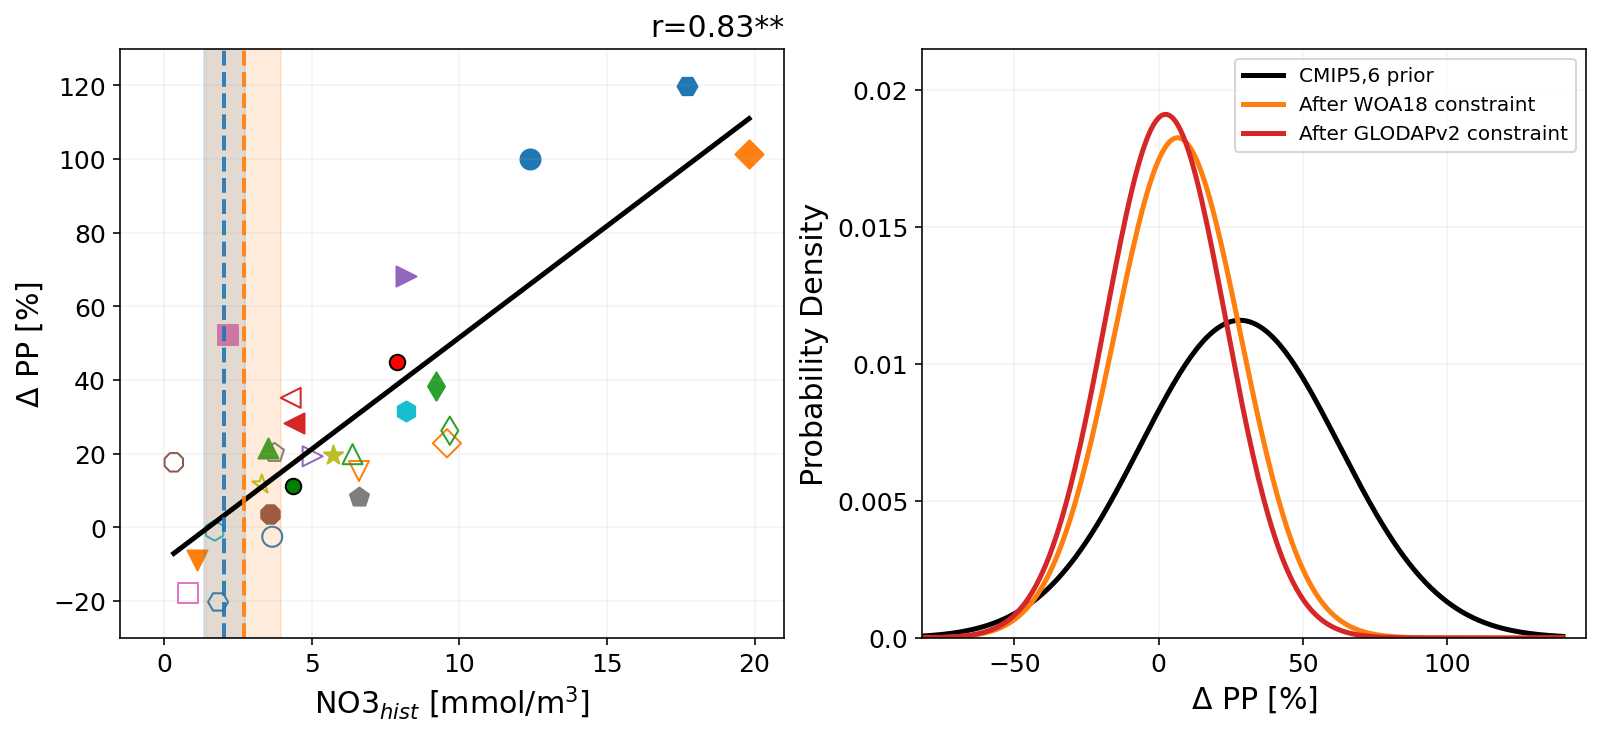

In [43]:
##########################################################################################
### Combine CMIP5 and CMIP6 Data to One array
##########################################################################################

tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3
tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_PP
tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_PP

tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

tmp_x = tmp_x[~np.isnan(tmp_y)]
tmp_y = tmp_y[~np.isnan(tmp_y)]

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


##########################################################################################
### Calculate NO3 PDF for WOA in the Arctic Ocean
##########################################################################################
mu_WOA_NO3        = NO3_WOA_mean.values
sigma_WOA_NO3     = NO3_WOA_std.values
PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


##########################################################################################
### Calculate NO3 PDF for GLODAP in the Arctic Ocean
##########################################################################################
mu_GLODAP_NO3     = NO3_GLODAP_mean.values
sigma_GLODAP_NO3  = NO3_GLODAP_std.values
PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


##########################################################################################
### Calculate Constrained CHL PDF with WOA, GLODAP Observation
##########################################################################################
PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


##########################################################################################
### Calculate CMIP meand and STD
##########################################################################################
tmp_mean = tmp_y.mean("model_name").values
tmp_std  = tmp_y.std("model_name").values

P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

print("Mean \u0394PP : {:4.1f}% (\u00B1{:4.1f}%) (CMIP5 and CMIP6)".format(tmp_mean,tmp_std))
print("Mean \u0394PP : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by WOA18)".format(mean_WOA,sigma_WOA))
print("Mean \u0394PP : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by GLODAPv2)".format(mean_GLODAP,sigma_GLODAP))

fig, axes = plt.subplots(1,2,figsize=(11,5),constrained_layout=True)

##########################################################################################
### Scatter Plot for NO3_Hist and PP Difference
##########################################################################################
plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                  tmp_x_CMIP5.model_name.values,'none',False,axes[0])
plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                  tmp_x_CMIP6.model_name.values,'filled',False,axes[0])

axes[0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
axes[0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')


##########################################################################################
### Linear-Regression for NO3_Hist and PP Difference
##########################################################################################
xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                          tmp_y.values.reshape(-1,1))
tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

axes[0].plot(xp,yp.T,'k-',linewidth=2.5)


##########################################################################################
### Mean NO3 and its Uncertainty in WOA and GLODAP
##########################################################################################
axes[0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                color='tab:blue',alpha=0.15)
axes[0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                color='tab:orange',alpha=0.15)

axes[0].axvline(mu_GLODAP_NO3,
                linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
axes[0].axvline(mu_WOA_NO3,
                linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


##########################################################################################
### Constrained PDF of PP Projection in WOA and GLODAP
##########################################################################################
axes[1].plot(y,P,'k',linewidth=2.5,label="CMIP5,6 prior")
axes[1].plot(y,PDF_WOA,'tab:orange',linewidth=2.5,label="After WOA18 constraint")
axes[1].plot(y,PDF_GLODAP,'tab:red',linewidth=2.5,label="After GLODAPv2 constraint")


##########################################################################################
### Settings for Plots
##########################################################################################
axes[0].set_title("r={:4.2f}".format(tmp_corr)+"**",loc='right',fontsize=15)

axes[0].grid(alpha=0.15)
axes[0].set_xlim([-1.5,21]) 
axes[0].set_ylim([-30,130])  ## SSP5-85 [PP]


axes[1].set_xlim([tmp_mean-110,tmp_mean+120])
axes[1].grid(alpha=0.15)
axes[1].legend(fontsize=10)

axes[0].set_ylabel("$\Delta$ PP [%]",fontsize=15)
axes[0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
axes[1].set_xlabel("$\Delta$ PP [%]",fontsize=15)
axes[1].set_ylabel("Probability Density",fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)

axes[1].set_ylim([0.00,0.0215])
axes[1].set_yticks([0,0.005,0.01,0.015,0.02])
axes[1].set_yticklabels([0.00,0.005,0.010,0.015,0.02], fontsize=12.5)

##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PDF_CMIP56_SSP585_PP_NO3_LAT"+str(latS)+str(latN)+".pdf"
plt.savefig(dir_name+file_name)

### 2.2) Emergent Constraint for Chlorophyll

Mean ΔCHL : -13.5% (±48.8%) (CMIP5 and CMIP6)
Mean ΔCHL : -44.8% (±28.0%) (Constrained by WOA18)
Mean ΔCHL : -51.3% (±26.1%) (Constrained by GLODAPv2)


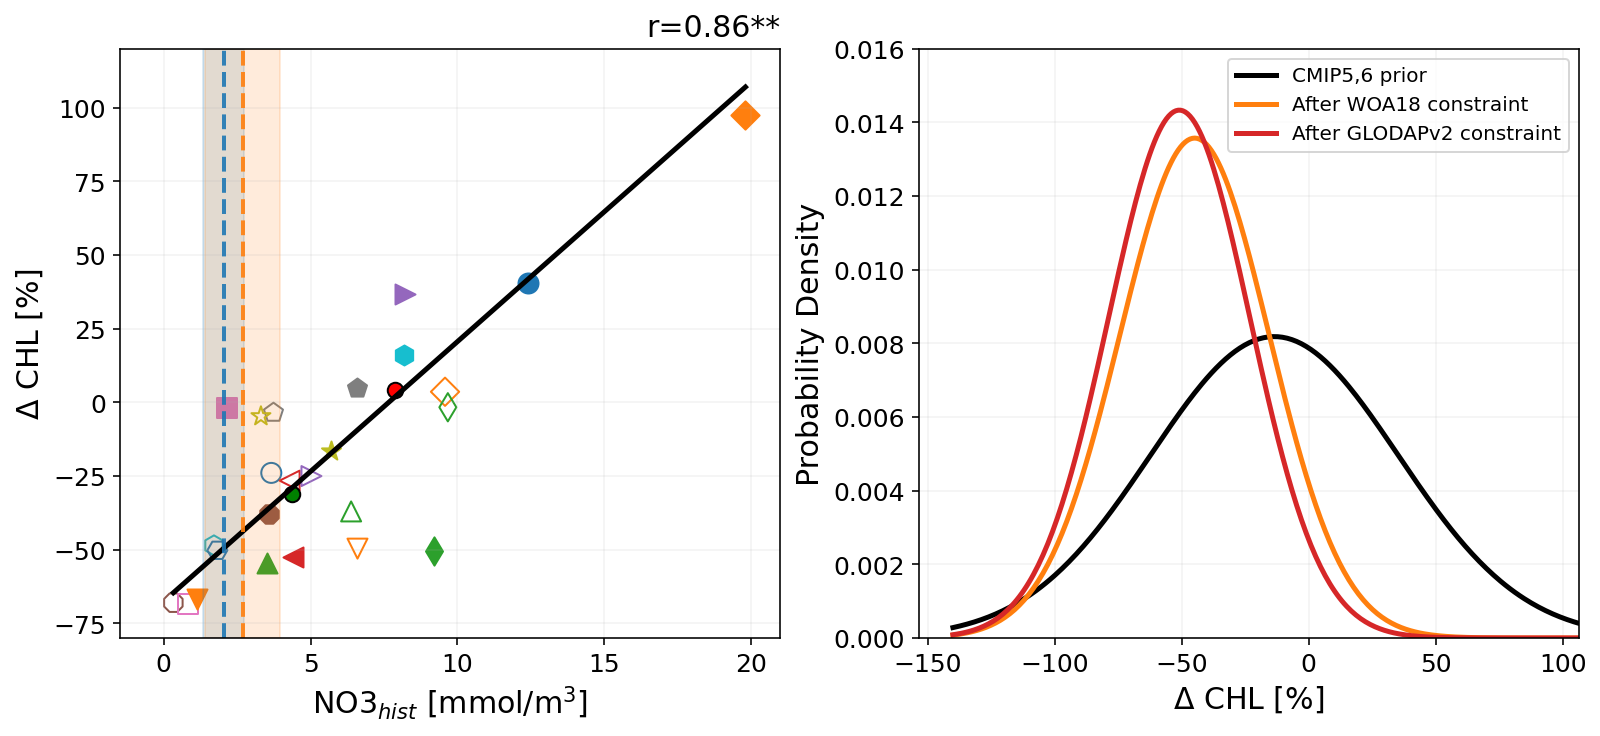

In [44]:
##########################################################################################
### Combine CMIP5 and CMIP6 Data to One array
##########################################################################################

tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL

tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3
tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL

tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

tmp_x = tmp_x[~np.isnan(tmp_y)]
tmp_y = tmp_y[~np.isnan(tmp_y)]

x  = np.linspace(-5,20,251)
y  = np.linspace(-140,140,301)


##########################################################################################
### Calculate NO3 PDF for WOA in the Arctic Ocean
##########################################################################################
mu_WOA_NO3        = NO3_WOA_mean.values
sigma_WOA_NO3     = NO3_WOA_std.values
PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


##########################################################################################
### Calculate NO3 PDF for GLODAP in the Arctic Ocean
##########################################################################################
mu_GLODAP_NO3     = NO3_GLODAP_mean.values
sigma_GLODAP_NO3  = NO3_GLODAP_std.values
PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


##########################################################################################
### Calculate Constrained CHL PDF with WOA, GLODAP Observation
##########################################################################################
PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)


##########################################################################################
### Calculate CMIP meand and STD
##########################################################################################
tmp_mean = tmp_y.mean("model_name").values
tmp_std  = tmp_y.std("model_name").values

P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))

print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (CMIP5 and CMIP6)".format(tmp_mean,tmp_std))
print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by WOA18)".format(mean_WOA,sigma_WOA))
print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by GLODAPv2)".format(mean_GLODAP,sigma_GLODAP))

fig, axes = plt.subplots(1,2,figsize=(11,5),constrained_layout=True)

##########################################################################################
### Scatter Plot for NO3_Hist and CHL Difference
##########################################################################################
plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                  tmp_x_CMIP5.model_name.values,'none',False,axes[0])
plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                  tmp_x_CMIP6.model_name.values,'filled',False,axes[0])

axes[0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
axes[0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')


##########################################################################################
### Linear-Regression for NO3_Hist and CHL Difference
##########################################################################################
xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                          tmp_y.values.reshape(-1,1))
tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

axes[0].plot(xp,yp.T,'k-',linewidth=2.5)


##########################################################################################
### Mean NO3 and its Uncertainty in WOA and GLODAP
##########################################################################################
axes[0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                color='tab:blue',alpha=0.15)
axes[0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                color='tab:orange',alpha=0.15)

axes[0].axvline(mu_GLODAP_NO3,
                linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
axes[0].axvline(mu_WOA_NO3,
                linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


##########################################################################################
### Constrained PDF of CHL Projection in WOA and GLODAP
##########################################################################################
axes[1].plot(y,P,'k',linewidth=2.5,label="CMIP5,6 prior")
axes[1].plot(y,PDF_WOA,'tab:orange',linewidth=2.5,label="After WOA18 constraint")
axes[1].plot(y,PDF_GLODAP,'tab:red',linewidth=2.5,label="After GLODAPv2 constraint")


##########################################################################################
### Settings for Plots
##########################################################################################
axes[0].set_title("r={:4.2f}".format(tmp_corr)+"**",loc='right',fontsize=15)

axes[0].grid(alpha=0.15)
# axes[0].set_xlim([-1.5,21]) 
# axes[0].set_ylim([-90,150])
axes[0].set_xlim([-1.5,21]) 
axes[0].set_ylim([-80,120])

axes[1].set_xlim([tmp_mean-140,tmp_mean+120])
axes[1].grid(alpha=0.15)
axes[1].legend(fontsize=10)

axes[0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
axes[0].set_ylabel("$\Delta$ CHL [%]",fontsize=15)


axes[1].set_xlabel("$\Delta$ CHL [%]",fontsize=15)
axes[1].set_ylabel("Probability Density",fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=12.5)
axes[1].tick_params(axis='both', which='major', labelsize=12.5)

axes[1].set_ylim([0.00,0.016])
# axes[1].set_yticks([0,0.005,0.01,0.015])
# axes[1].set_yticklabels([0.00,0.005,0.010,0.015], fontsize=12.5)


##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name  = "./RESULT/"
file_name = "Scat_PDF_CMIP56_SSP585_CHL_NO3_LAT"+str(latS)+str(latN)+".pdf"

plt.savefig(dir_name+file_name)

### 2.3) Emergent Constraint for Arctic Chlorophyll in 3 Scenarios

[SSP1-2.6]
Mean ΔCHL : -5.9% (±22.7%) (CMIP5 and CMIP6)
Mean ΔCHL : -19.2% (±18.4%) (Constrained by WOA18)
Mean ΔCHL : -21.3% (±18.6%) (Constrained by GLODAPv2)

CMIP[60.37], WOA[85.00], GLODAP[87.28]

[SSP2-4.5]
Mean ΔCHL : -11.5% (±29.7%) (CMIP5 and CMIP6)
Mean ΔCHL : -29.3% (±19.2%) (Constrained by WOA18)
Mean ΔCHL : -32.7% (±19.5%) (Constrained by GLODAPv2)

CMIP[65.12], WOA[93.49], GLODAP[95.20]

[SSP5-8.5]
Mean ΔCHL : -13.5% (±48.8%) (CMIP5 and CMIP6)
Mean ΔCHL : -45.0% (±27.1%) (Constrained by WOA18)
Mean ΔCHL : -50.9% (±27.6%) (Constrained by GLODAPv2)

CMIP[60.46], WOA[95.04], GLODAP[96.60]



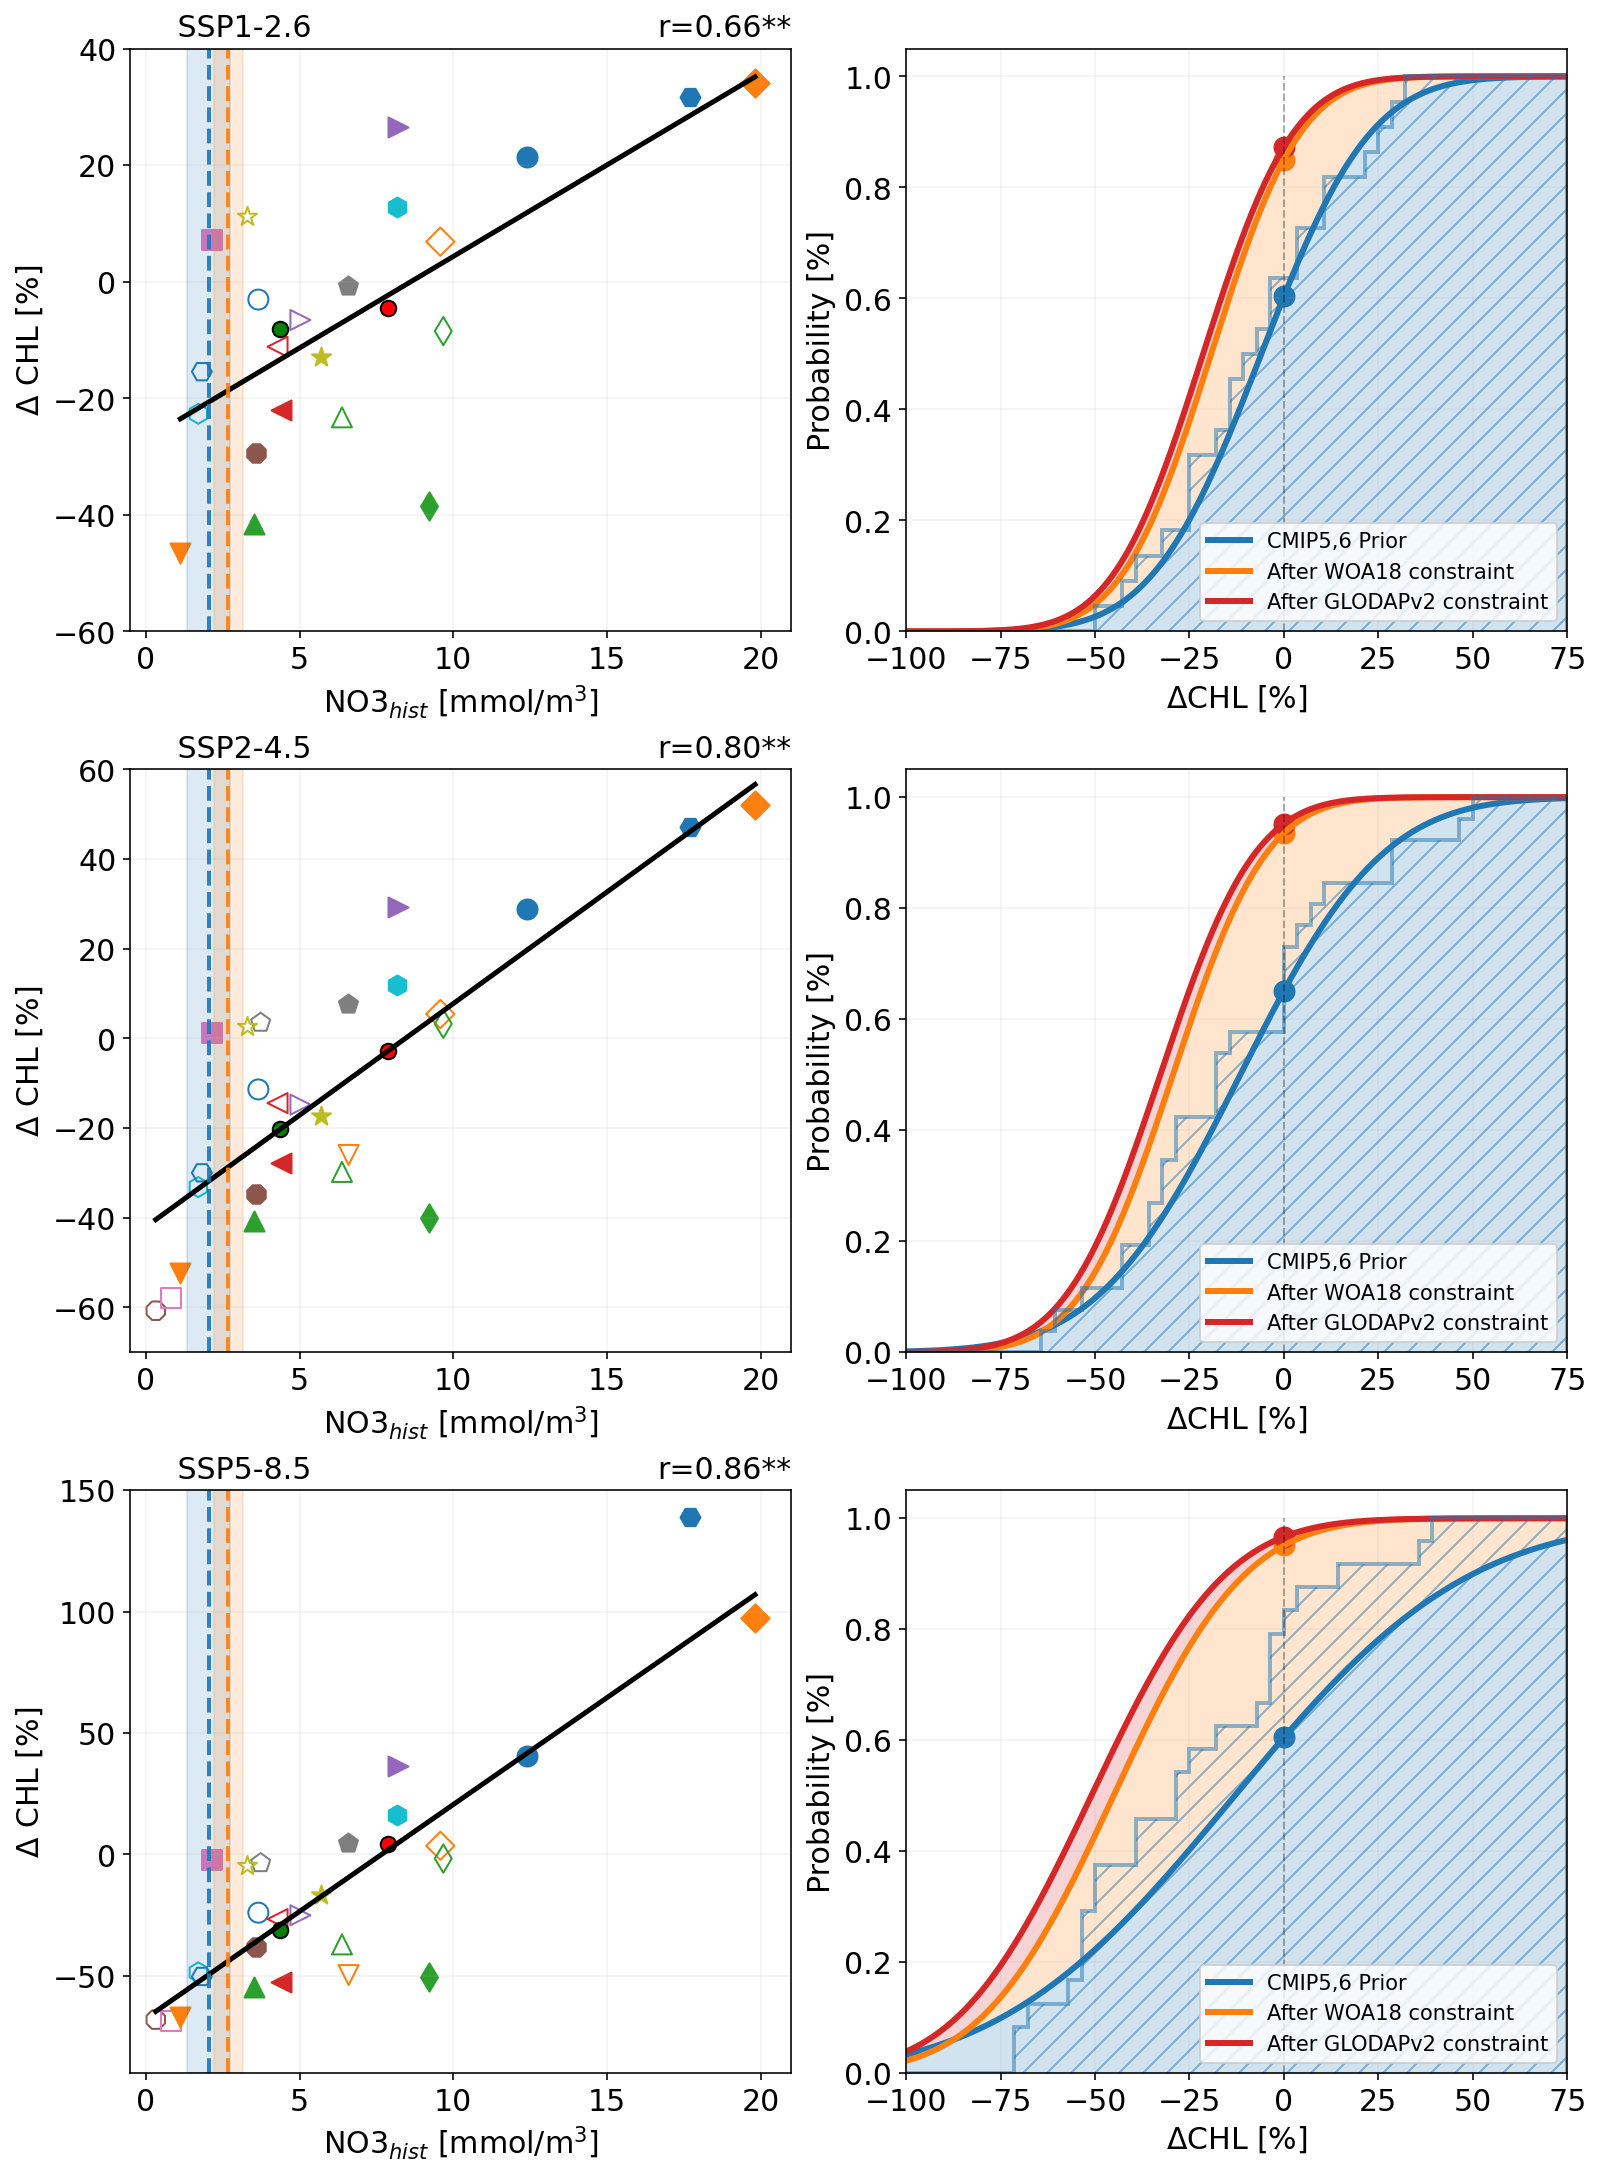

In [50]:
fig, axes = plt.subplots(3,2,figsize=(11,15),constrained_layout=True)

scenario_list = [126,245,585]

for ind_scen in range(3):
    
    ##########################################################################################
    ### Combine CMIP5 and CMIP6 Data to One array
    ##########################################################################################
    tmp_x_CMIP5 = 1e+3*CMIP5_mean_hist_NO3
    tmp_x_CMIP6 = 1e+3*CMIP6_mean_hist_NO3

    scenario = scenario_list[ind_scen]    
    if (scenario == 126):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_126_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_126_CHL
        y_range     = [-60,40]
        scenario_name = "SSP1-2.6"
    if (scenario == 245):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_245_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_245_CHL
        y_range     = [-70,60]    
        scenario_name = "SSP2-4.5"    
    if (scenario == 585):
        tmp_y_CMIP5 = 1e+2*CMIP5_delta_ssp_585_CHL
        tmp_y_CMIP6 = 1e+2*CMIP6_delta_ssp_585_CHL
        y_range     = [-90,150]
        scenario_name = "SSP5-8.5"
    

    tmp_x = xr.concat([tmp_x_CMIP5,tmp_x_CMIP6],dim='model_name')
    tmp_y = xr.concat([tmp_y_CMIP5,tmp_y_CMIP6],dim='model_name')

    tmp_x = tmp_x[~np.isnan(tmp_y)]
    tmp_y = tmp_y[~np.isnan(tmp_y)]

    x  = np.linspace(-5,20,251)
    y  = np.linspace(-140,140,3001)


    ##########################################################################################
    ### Calculate NO3 PDF for WOA in the Arctic Ocean
    ##########################################################################################
    mu_WOA_NO3        = NO3_WOA_mean.values
    sigma_WOA_NO3     = NO3_WOA_err.values
    PDF_WOA_NO3       = calc_GAUSSIAN_PDF(mu_WOA_NO3,sigma_WOA_NO3,x)


    ##########################################################################################
    ### Calculate NO3 PDF for GLODAP in the Arctic Ocean
    ##########################################################################################
    mu_GLODAP_NO3     = NO3_GLODAP_mean.values
    sigma_GLODAP_NO3  = NO3_GLODAP_std.values
    PDF_GLODAP_NO3    = calc_GAUSSIAN_PDF(mu_GLODAP_NO3,sigma_GLODAP_NO3,x)


    ##########################################################################################
    ### Calculate Constrained CHL PDF with WOA, GLODAP Observation
    ##########################################################################################
    PDF_WOA,    sigma_WOA,    mean_WOA    = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_WOA_NO3)
    PDF_GLODAP, sigma_GLODAP, mean_GLODAP = calc_PDF_EC(tmp_x,tmp_y,x,y,PDF_GLODAP_NO3)

    
    ##########################################################################################
    ### Calculate CMIP meand and STD
    ##########################################################################################
    tmp_mean = tmp_y.mean("model_name").values
    tmp_std  = tmp_y.std("model_name").values

    P = 1/np.sqrt(2*np.pi*tmp_std**2)*np.exp(-(y-tmp_mean)**2/(2*tmp_std**2))


    print("["+str(scenario_name)+"]")
    print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (CMIP5 and CMIP6)".format(tmp_mean,tmp_std))
    print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by WOA18)".format(mean_WOA,sigma_WOA))
    print("Mean \u0394CHL : {:4.1f}% (\u00B1{:4.1f}%) (Constrained by GLODAPv2)".format(mean_GLODAP,sigma_GLODAP))

    

    ##########################################################################################
    ### Linear-Regression for NO3_Hist and CHL Difference
    ##########################################################################################
    plot_scat_regline(tmp_x_CMIP5,tmp_y_CMIP5,
                      tmp_x_CMIP5.model_name.values,'none',False,axes[ind_scen][0])
    plot_scat_regline(tmp_x_CMIP6,tmp_y_CMIP6,
                      tmp_x_CMIP6.model_name.values,'filled',False,axes[ind_scen][0])
    print("")
    
    xp, yp = calc_lin_regline(tmp_x.values.reshape(-1,1),
                              tmp_y.values.reshape(-1,1))
    tmp_corr, tmp_pval = calc_corr_pval_nan(tmp_x,tmp_y)

    axes[ind_scen][0].plot(xp,yp.T,'k-',linewidth=2.5)

    ##########################################################################################
    ### Mean NO3 and its Uncertainty in WOA and GLODAP
    ##########################################################################################
    axes[ind_scen][0].axvspan(mu_GLODAP_NO3-sigma_GLODAP_NO3,mu_GLODAP_NO3+sigma_GLODAP_NO3,
                    color='tab:blue',alpha=0.15)
    axes[ind_scen][0].axvspan(mu_WOA_NO3-sigma_WOA_NO3,mu_WOA_NO3+sigma_WOA_NO3,
                    color='tab:orange',alpha=0.15)

    axes[ind_scen][0].axvline(mu_GLODAP_NO3,
                    linestyle='--',color='tab:blue',linewidth=2.,alpha=0.9,label='GLODAPv2')
    axes[ind_scen][0].axvline(mu_WOA_NO3,
                    linestyle='--',color='tab:orange',linewidth=2.,alpha=0.9,label='WOA13')


    axes[ind_scen][0].scatter(tmp_x_CMIP5.mean("model_name"),tmp_y_CMIP5.mean("model_name"),
                    facecolors='green',edgecolors='black',s=60,label='CMIP5 Mean')
    axes[ind_scen][0].scatter(tmp_x_CMIP6.mean("model_name"),tmp_y_CMIP6.mean("model_name"),
                    facecolors='red',edgecolors='black',s=60,label='CMIP6 Mean')
    
    ##########################################################################################
    ### Settings for Scatter Plots
    ##########################################################################################    
    if   (tmp_pval <= 0.05): sig_type = "**"
    elif (tmp_pval <= 0.10): sig_type = "*"
    else:                    sig_type=""
        
    axes[ind_scen][0].set_title("r={:4.2f}".format(tmp_corr)+sig_type,loc='right',fontsize=15)
    axes[ind_scen][0].set_title("     "+str(scenario_name),loc='left',fontsize=15)

    axes[ind_scen][0].grid(alpha=0.15)
    axes[ind_scen][0].set_xlim([-0.5,21])

    axes[ind_scen][0].set_ylim(y_range)  ## SSP5-85 [CHL]
    axes[ind_scen][0].set_ylabel("$\Delta$ CHL [%]",fontsize=15)
    axes[ind_scen][0].set_xlabel("NO3$_{hist}$ [mmol/m$^3$]",fontsize=15)
    axes[ind_scen][0].tick_params(axis='both', which='major', labelsize=15)
    
    
    ##########################################################################################
    ### Calculate Cumulative Density Functions
    ##########################################################################################        
    CDF_CMIP   = np.zeros(len(P))
    CDF_WOA    = np.zeros(len(PDF_WOA))
    CDF_GLODAP = np.zeros(len(PDF_GLODAP))

    for it in range(1,len(PDF_WOA)):
        dy = (y[1]-y[0])
        CDF_CMIP[it]    = CDF_CMIP[it-1]    + P[it] * dy
        CDF_WOA[it]     = CDF_WOA[it-1]     + PDF_WOA[it] * dy
        CDF_GLODAP[it]  = CDF_GLODAP[it-1]  + PDF_GLODAP[it] * dy    

        
    ##########################################################################################
    ### Plot Cumulative Density Functions based on Gaussian Distribution
    ##########################################################################################        
    axes[ind_scen][1].fill_between(y,CDF_GLODAP,CDF_WOA,color='tab:red',alpha=0.2)
    axes[ind_scen][1].fill_between(y,CDF_WOA,CDF_CMIP,color='tab:orange',alpha=0.2)
    axes[ind_scen][1].fill_between(y,CDF_CMIP,0,color='tab:blue',alpha=0.2)

    axes[ind_scen][1].plot(y,CDF_CMIP,color='tab:blue',linewidth=3,label='CMIP5,6 Prior')
    axes[ind_scen][1].plot(y,CDF_WOA,color='tab:orange',linewidth=3,label='After WOA18 constraint')
    axes[ind_scen][1].plot(y,CDF_GLODAP,color='tab:red',linewidth=3,label='After GLODAPv2 constraint')

    
    ##########################################################################################
    ### Plot Cumulative Density Function based on Real CMIP Distribution
    ##########################################################################################        
    axes[ind_scen][1].hist(tmp_y, bins=np.linspace(-100,75),density=True, histtype='step', 
                           cumulative=1,hatch='//',alpha=0.5,color='tab:blue',linewidth=2)
    
    
    ##########################################################################################
    ### Plot Scatters on CHL = 0 Points
    ##########################################################################################        
    axes[ind_scen][1].scatter(0,CDF_CMIP[1500],color='tab:blue',s=100)
    axes[ind_scen][1].scatter(0,CDF_WOA[1500],color='tab:orange',s=100)
    axes[ind_scen][1].scatter(0,CDF_GLODAP[1500],color='tab:red',s=100)
    print("CMIP[{:4.2f}], WOA[{:4.2f}], GLODAP[{:4.2f}]".format(\
                                                100*CDF_CMIP[1500],100*CDF_WOA[1500],100*CDF_GLODAP[1500]))
    print("")
    
    ##########################################################################################
    ### Settings for CDF Plots
    ##########################################################################################        
    axes[ind_scen][1].legend(fontsize=10.5,loc='lower right')
    axes[ind_scen][1].plot(np.zeros(50),np.linspace(0,1),'k--',linewidth=1,alpha=0.3)

    axes[ind_scen][1].set_xlim([-100,75])
    axes[ind_scen][1].set_xlabel("$\Delta$CHL [%]",fontsize=15)
    axes[ind_scen][1].set_ylabel("Probability [%]",fontsize=15)
    axes[ind_scen][1].grid(alpha=0.15)
    
    axes[ind_scen][1].tick_params(axis='both', which='major', labelsize=15)

    
##########################################################################################
### Save output to pdf file
##########################################################################################
dir_name = "./RESULT/"
file_name = "Scat_PDF_CMIP5_CHL_NO3_LAT_"+str(latS)+str(latN)+".pdf"
plt.savefig(dir_name+file_name)